In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib

from pcap_processor import calculate_features



In [2]:
# Check if CUDA (NVIDIA's GPU programming toolkit) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [3]:
# Load the tensors from the .pt files
data_tensors = torch.load('data_tensors_10s_0.01s.pt')
target_tensors = torch.load('target_tensors_10s_0.01s.pt')

print("Data tensors and target tensors loaded successfully!")

# Example usage: Checking the shapes of the loaded tensors
print(f"Number of data samples: {len(data_tensors)}")
print(f"Shape of first data sample: {data_tensors[0].shape}")
print(f"Shape of target tensor: {target_tensors.shape}")

Data tensors and target tensors loaded successfully!
Number of data samples: 3000
Shape of first data sample: torch.Size([1000, 22])
Shape of target tensor: torch.Size([3000])


In [4]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]



In [5]:
# normalize the target tensors
target_mean = target_tensors.mean()
target_std = target_tensors.std()

# make a function to denormalize a prediction
def denormalize(tensor):
    return tensor * target_std + target_mean

target_tensors = (target_tensors - target_mean) / target_tensors.std()

train_data, test_data, train_targets, test_targets = train_test_split(
    data_tensors, target_tensors, test_size=0.2, random_state=42
)

# Create datasets and data loaders
train_dataset = PacketCaptureDataset(train_data, train_targets)
test_dataset = PacketCaptureDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
input_size = len(
    train_dataset[0][0][0]
)  # Assuming all packet captures have the same structure
hidden_size = 64
output_size = 1
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [22]:
# FILEPATH: /home/ziv/Desktop/coding/speedtest-research/cs293n/model/lstm.ipynb
model.load_state_dict(torch.load('model_weights_10s_0.01s.pt'))

# started with 75 epochs
# up to 90 total
# up to 215 total
# up to 519 total
# up to 526 total
# up to 541 total
# up to 580 total
# finished 600 total
num_epochs = 20

model.train()
with tqdm(total=num_epochs) as pbar:
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        pbar.update(1)


Epoch 20, Loss: 2.5198: 100%|██████████| 20/20 [32:15<00:00, 96.77s/it]


In [8]:
# save the weights of the model to a file
torch.save(model.state_dict(), 'model_weights_10s_0.01s.pt')

In [9]:
total_absolute_error = 0
num_samples = len(test_targets)

for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    absolute_error = abs(predicted_value - actual_value)
    total_absolute_error += absolute_error

average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error: {average_absolute_error}")


Average Absolute Error: 0.20913750060853392


In [10]:
# get the average absolute error for the denormalized values
total_absolute_error = 0
num_samples = len(test_targets)

for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    absolute_error = abs(predicted_value - actual_value)
    total_absolute_error += absolute_error

average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error (Denormalized): {average_absolute_error}")


Average Absolute Error (Denormalized): 23.636491775512695


In [11]:
# get the median absolute error
absolute_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Median Absolute Error: 0.03842678666114807


In [12]:
# get the median absolute error for the denormalized values
absolute_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error (Denormalized): {median_absolute_error}")


Median Absolute Error (Denormalized): 4.342951774597168


In [13]:
# get the mean square error
total_square_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error: {mean_square_error}")


Mean Square Error: 0.7066858371570507


In [14]:
# get the mean square error for the denormalized values
total_square_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error (Denormalized): {mean_square_error}")


Mean Square Error (Denormalized): 9026.6904296875


In [15]:
# print each actual vs prediction value
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: -0.21166448295116425, Predicted: -0.17924606800079346
Actual: -0.21323460340499878, Predicted: -0.23640191555023193
Actual: 0.13402138650417328, Predicted: -0.029794752597808838
Actual: -0.2292727828025818, Predicted: -0.20113611221313477
Actual: -0.21166515350341797, Predicted: -0.21844720840454102
Actual: -0.2560468316078186, Predicted: -0.2778984308242798
Actual: -0.24280256032943726, Predicted: -0.13918328285217285
Actual: -0.2118397206068039, Predicted: -0.24511229991912842
Actual: -0.2565232217311859, Predicted: -0.3004584312438965
Actual: -0.2520920932292938, Predicted: -0.20905792713165283
Actual: -0.25963708758354187, Predicted: -0.3238835334777832
Actual: -0.2595170736312866, Predicted: -0.2930387258529663
Actual: -0.22725093364715576, Predicted: -0.2203141450881958
Actual: -0.23798316717147827, Predicted: -0.25500810146331787
Actual: 3.107248306274414, Predicted: 0.9996546506881714
Actual: 7.124375820159912, Predicted: 0.730464518070221
Actual: 0.36677077412605286, P

In [16]:
# print each actual vs prediction value for denormalized values
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")


Actual: 5.705404281616211, Predicted: 9.36929702758789
Actual: 5.527950286865234, Predicted: 2.90960693359375
Actual: 44.774436950683594, Predicted: 26.26011848449707
Actual: 3.715333938598633, Predicted: 6.8953094482421875
Actual: 5.705327987670898, Predicted: 4.9388275146484375
Actual: 0.6893596649169922, Predicted: -1.780282974243164
Actual: 2.1862125396728516, Predicted: 13.897149085998535
Actual: 5.685598373413086, Predicted: 1.9251689910888672
Actual: 0.6355190277099609, Predicted: -4.329988479614258
Actual: 1.1363201141357422, Predicted: 5.999994277954102
Actual: 0.28359413146972656, Predicted: -6.977468490600586
Actual: 0.29715728759765625, Predicted: -3.491422653198242
Actual: 3.9438400268554688, Predicted: 4.7278289794921875
Actual: 2.73089599609375, Predicted: 0.8067569732666016
Actual: 380.8052673339844, Predicted: 142.6073455810547
Actual: 834.8165283203125, Predicted: 112.18377685546875
Actual: 71.07951354980469, Predicted: 59.65229034423828
Actual: 1.177499771118164, Pre

In [17]:
# calculate the average percentage error of the model
total_percentage_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error: {average_percentage_error}%")
# print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors: {percentage_errors_std}")


# remove the max 2 percent of the errors and calculate the average percentage error
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%): {average_percentage_error * 100}%")
# print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%): {percentage_errors_std}")


Average Percentage Error: 156.13875724543186%
Standard Deviation of Percentage Errors: 10.878551962007979
Average Percentage Error (Without Top 2%): 41.58320236206055%
Standard Deviation of Percentage Errors (Without Top 2%): 10.985255639325292


In [18]:
# calculate the average percentage error of the model for denormalized values
total_percentage_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error (Denormalized): {average_percentage_error}%")

# print the standard deviation of the percentage errors for denormalized values
percentage_errors = []  
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Denormalized): {percentage_errors_std}")

# remove the max 2 percent of the errors and calculate the average percentage error for denormalized values
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%, Denormalized): {average_percentage_error * 100}%")
# print the standard deviation of the percentage errors for denormalized values
percentage_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): {percentage_errors_std}")



Average Percentage Error (Denormalized): 562.756103515625%
Standard Deviation of Percentage Errors (Denormalized): 17.268680572509766
Average Percentage Error (Without Top 2%, Denormalized): 41.58320236206055%
Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): 17.43108558654785


In [19]:
# calculate the median percentage error of the model
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")


median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error: {median_percentage_error}%")


Median Percentage Error: 17.236923475145495%


In [20]:
# calculate the median percentage error of the model for denormalized values
percentage_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error (Denormalized): {median_percentage_error}%")

Median Percentage Error (Denormalized): 98.45077991485596%


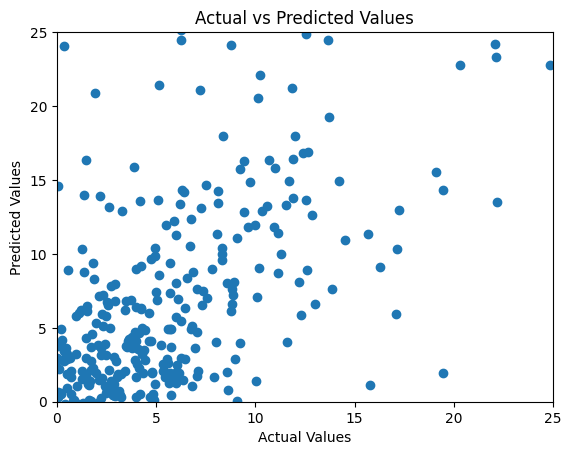

In [21]:
# plot the denormalized values for the actual and predicted values on testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()

